In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../..")

import h5py
import scipy
import sympy
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sympy import Symbol, zeros, Function, MatrixSymbol

# import created modules
from hamiltonian.states import CoupledBasisState
from hamiltonian.generate_hamiltonian import generate_X_hamiltonian_function, generate_B_hamiltonian_function, \
                                                generate_diagonalized_hamiltonian, generate_total_hamiltonian, \
                                            generate_reduced_X_hamiltonian, generate_reduced_B_hamiltonian
from hamiltonian.utils import ni_range, matrix_to_states, find_exact_states, reduced_basis_hamiltonian, \
                                find_state_idx_from_state, reorder_evecs, generate_coupled_ground_states

from couplings.utils import ED_ME_mixed_state, collapse_matrices, generate_superoperator, \
                            generate_flat_superoperator, generate_sharp_superoperator, \
                            check_approx_state_exact_state
from couplings.generate_coupling import optical_coupling_matrix, microwave_coupling_matrix, \
                                        generate_laser_D, generate_microwave_D,\
                                        generate_coupling_field

from symbolic import generate_density_matrix_symbolic, generate_system_of_equations, generate_symbolic_hamiltonian,\
                        system_of_equations_to_lines, generate_symbolic_detunings
from symbolic.utils import subs_rabi_rate

from utils.plot_utils import set_fontsize
from utils import population, J_levels, J_slice, delete_J_level

from hamiltonian.generate_states import generate_ground_states_approx, generate_excited_states_approx

In [2]:
script_dir = Path().parent.absolute().parent.parent
script_dir

WindowsPath('C:/Users/Olivier/Documents/GitHub/optical-bloch')

## X-state

Define what states from the $X ^1\Sigma$ electronic state are to be included in the simulation.

In [3]:
Jg = [2,4]
#Generate a list of approximate ground states. The exact ground states are determined within the main
#simulation function
ground_states_approx = generate_ground_states_approx(Jg)

ground_states, H_X_red = generate_reduced_X_hamiltonian(ground_states_approx)

In [4]:
for s in ground_states_approx:
    s.print_state()

+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = -2, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 2, mF = 2, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 5/2, F = 2, mF = -2, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 5/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 2, F1 = 5/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P

## B-state
Define what states from the $B ^3\Pi_1$ electronic state are to be included in the simulation. Only need the states that are coupled to J = 1 in the X-state by the laser.

In [5]:
# define what states are to be included in the simulation
# specify J, F1 and F for each state separately
J_excited = [3]
F1_excited = [5/2]
F_excited = [2]

excited_states_approx = generate_excited_states_approx(J_excited, F_excited, F1_excited, P=-1)

excited_states, H_B_red = generate_reduced_B_hamiltonian(excited_states_approx)

In [6]:
for s in excited_states_approx:
    s.print_state()

+1.0000+0.0000j x |B, J = 3, F1 = 5/2, F = 2, mF = -2, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 3, F1 = 5/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 3, F1 = 5/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 3, F1 = 5/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 3, F1 = 5/2, F = 2, mF = 2, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>


Now generate the excited state Hamiltonian to get the reduced B state Hamiltonian

## Total Internal Hamiltonian

In [7]:
H_int, V_ref_int = generate_total_hamiltonian(H_X_red, H_B_red)
#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

## Laser coupling
### Calculating transition R(2) F'=4 F1'=7/2

In [8]:
#Define ground states for laser driven transition
Js = [2]
ground_states_laser_approx =  generate_ground_states_approx(Js)

#Define excited states for laser
excited_states_laser_approx = excited_states_approx

#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=2,F1=5/2,F=3,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**2, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=3,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)

In [9]:
%%time
laser_couplings = generate_coupling_field(ground_main_approx, excited_main_approx, 
                                        ground_states_laser_approx, excited_states_laser_approx,
                                        H_rot, QN, V_ref_int, pol_main = np.array([0,0,1]),
                                        pol_vec = [np.array([0,0,1]), np.array([1,0,0])],
                                        nprocs = 6)

Wall time: 44 s


In [10]:
Dl = generate_laser_D(H_rot, QN, 
                      laser_couplings[0]['ground_main'], laser_couplings[0]['excited_main'], 
                      laser_couplings[0]['excited_states'], Δ = 0)

## Total Hamiltonian

[-2.25284612e+06 -2.25283609e+06 -2.25282607e+06 -1.97310753e+06
 -1.97311172e+06 -1.97311590e+06 -1.97312009e+06 -1.97312428e+06
 -2.21287742e+05 -2.21287155e+05 -2.21286568e+05 -2.21285980e+05
 -2.21285392e+05  2.06024475e+01  1.37347717e+01  6.86779785e+00
  0.00000000e+00 -6.86822510e+00 -1.37359314e+01 -2.06041260e+01
  5.86485893e+11  5.86485893e+11  5.86485893e+11  5.86485893e+11
  5.86485893e+11  5.86485893e+11  5.86485893e+11  5.86486412e+11
  5.86486412e+11  5.86486412e+11  5.86486412e+11  5.86486412e+11
  5.86486412e+11  5.86486412e+11  5.86486412e+11  5.86486412e+11
  5.86489500e+11  5.86489500e+11  5.86489500e+11  5.86489500e+11
  5.86489500e+11  5.86489500e+11  5.86489500e+11  5.86489500e+11
  5.86489500e+11  5.86489958e+11  5.86489958e+11  5.86489958e+11
  5.86489958e+11  5.86489958e+11  5.86489958e+11  5.86489958e+11
  5.86489958e+11  5.86489958e+11  5.86489958e+11  5.86489958e+11
 -1.25661621e+01 -6.28356934e+00  0.00000000e+00  6.28350830e+00
  1.25662231e+01]


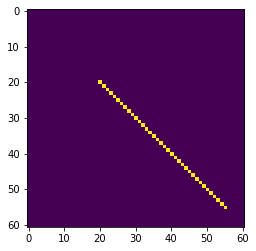

In [11]:
gnd_idx = QN.index(laser_couplings[0]['ground_main'])
H_rot = H_int.copy()
H_rot = H_rot - np.eye(H_rot.shape[0])*H_rot[gnd_idx,gnd_idx]
H_rot = H_rot + Dl
plt.imshow(H_rot.real)
print(np.diag(H_rot.real))

In [12]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.66it/s]


In [13]:
t = Symbol("t", real = True)
Plx = Symbol("Plx") # Polarization switching function for x
Plz = Symbol("Plz") # Polarization switching function for z

laser_fields = [(laser_couplings[0]['field']*Plz, laser_couplings[0]['main_coupling']), 
                (laser_couplings[1]['field']*Plx, laser_couplings[1]['main_coupling'])]
detunings = [[QN.index(exc) for exc in laser_couplings[0]['excited_states']]]

In [14]:
n_states = H_rot.shape[0]
H_symbolic, Ωs = generate_symbolic_hamiltonian(n_states, laser_fields)
Δ_symbolic, Δs = generate_symbolic_detunings(n_states, detunings)
H_symbolic += Δ_symbolic + H_rot

In [15]:
Ωl = Symbol('Ωl', real = True)
Ωlc = Symbol('Ωlᶜ', real = True)
H_symbolic = H_symbolic.subs(Ωs[0][0],Ωl).subs(Ωs[0][1],Ωlc)
H_symbolic = H_symbolic.subs(Ωs[1][0],Ωl).subs(Ωs[1][1],Ωlc)

# H_symbolic

In [16]:
def delete_row_column(arr, sl):
    sl = np.s_[sl.start:sl.stop-1]
    return np.delete(np.delete(arr, sl, axis = 0), sl, axis = 1)

def delete_row_column_symbolic(arr, sl):
    arr_copy = arr.copy()
    sl = np.s_[sl.start:sl.stop-1]
    deleted = 0
    for idx in range(sl.start, sl.stop):
        arr_copy.row_del(idx-deleted)
        arr_copy.col_del(idx-deleted)
        deleted += 1
    return arr_copy

def C_array_to_BR(C_array, Γ):
    return C_array.copy()**2 / Γ
    
def BR_to_C_array(BR, Γ):
    return np.sqrt(BR.copy()*Γ)

def compact_BR_array(BR_array, slice_compact):
    start, stop = slice_compact.start, slice_compact.stop
    new_shape = np.asarray(BR_array[0].shape) - (stop - start) + 1
    BR_array_new = []
    for BR in BR_array:
        id1,id2 = np.nonzero(BR)
        id1 = id1[0]
        id2 = id2[0]
        if (id1 not in range(start,stop)) & (id2 not in range(start,stop)):
            BR_array_new.append(delete_row_column(BR, slice_compact))
    
    BR_sum = np.zeros(new_shape, 'complex')
    BR_sum[start,:] = np.sum(BR_array,axis = 0)[slice_compact].sum(axis = 0)[-new_shape[0]:]
    for id1,id2 in zip(*np.nonzero(BR_sum)):
        BR_new = np.zeros(new_shape, 'complex')
        BR_new[id1,id2] = BR_sum[id1,id2]
        BR_array_new.append(BR_new)
    return np.array(BR_array_new)

In [17]:
slice_compact = np.s_[20:56]
BR = C_array_to_BR(C_array, Γ)
BR_compact = compact_BR_array(BR, slice_compact)
C_array_compact = BR_to_C_array(BR_compact, Γ)
H_symbolic_compact = delete_row_column_symbolic(H_symbolic, slice_compact)

In [18]:
%%time
system = generate_system_of_equations(H_symbolic_compact, C_array_compact, progress = False, fast = True)

Wall time: 6.78 s


In [19]:
%%time
# convert matrix to system of equations code
code_lines = system_of_equations_to_lines(system, nprocs = 6)

Wall time: 6.79 s


# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [20]:
# import julia
# julia.install()

In [21]:
from julia import Main

In [22]:
nprocs = 6

Main.eval("""
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

using Distributed
using BenchmarkTools
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    include("../../utils/general_ode_functions.jl")
end
""")

print(Main.eval("procs()"))

[1 2 3 4 5 6]


## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [23]:
ode_fun = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = p[1]
\t\tΔ = p[2]
\t\tωp = p[3]
\t\tϕ = p[4]
\t\tΩlᶜ = conj(Ωl)

\t\tPl = sin(ωp*t + ϕ)
\t\tPlx = (1-Pl)/2
\t\tPlz = (1+Pl)/2
"""

In [24]:
print(ode_fun)

function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ωl = p[1]
		Δ = p[2]
		ωp = p[3]
		ϕ = p[4]
		Ωlᶜ = conj(Ωl)

		Pl = sin(ωp*t + ϕ)
		Plx = (1-Pl)/2
		Plz = (1+Pl)/2



In [25]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [26]:
# making the function in Julia
Main.eval(f"@everywhere {ode_fun}")

### Generate density matrix

In [27]:
import scipy.constants as cst

def population(J, T, B=6.66733e9, n = 100):
    c = 2*np.pi*cst.hbar*B/(cst.k*T)
    g = lambda J: 4*(2*J+1)
    a = lambda J: -c*J*(J+1)
    Z = np.sum([g(i)*np.exp(a(i)) for i in range(n)])
    return g(J)*np.exp(a(J))/Z

In [28]:
def J_levels(J):
    return 4*(2*J + 1)

def J_slice(J):
    if J == 0:
        return np.s_[0:J_levels(0)]
    else:
        levels = J_levels(np.arange(J+1))
        return np.s_[np.sum(levels[:-1]):np.sum(levels)]

In [29]:
T = 6.3
ρ_ini = np.zeros(H_symbolic_compact.shape, dtype = 'complex')

index = 0
for J in [2]:
    p = population(J, T)
    levels = J_levels(J)
    sl = np.s_[index:index+levels]
    np.fill_diagonal(ρ_ini[sl, sl], p/levels)
    index += levels

ρ_ini /= np.diag(ρ_ini).sum()

In [30]:
Γ = 2*np.pi * 1.56e6


Main.Γ = Γ

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("""
@everywhere begin
    Γ = 2pi*1.56e6
    Ωl = 0.2Γ
    Δ = 0
    ωp = Γ
    ϕ = 0
    p = [Ωl, Δ, ωp, ϕ]
end
""")

In [31]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@time Lindblad_rhs!(du, ρ_ini, p, 0.)
tmp = 0
""")

Wall time: 14.5 s


0

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [32]:
Main.eval("""
tspan = (0.0, 30e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [33]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-7, reltol = 1e-4, progress = false);
tmp = 0
""");

Wall time: 8.47 s


0

In [34]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t")

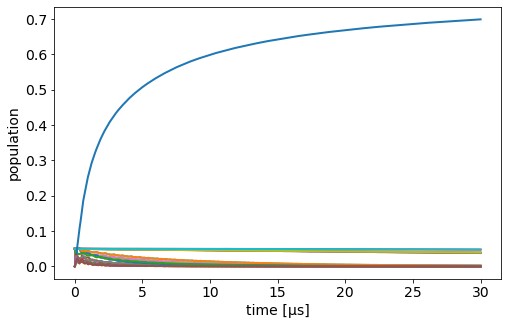

In [35]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in range(0,len(pop_results)):
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
# ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [36]:
print(f'{np.trapz(pop_results[-len(excited_states):].sum(axis = 0), t_array)*Main.Γ}')

1.8161261361168513


In [37]:
J2_indices = [idx for idx, s in enumerate(QN) if s.find_largest_component().J == 2]

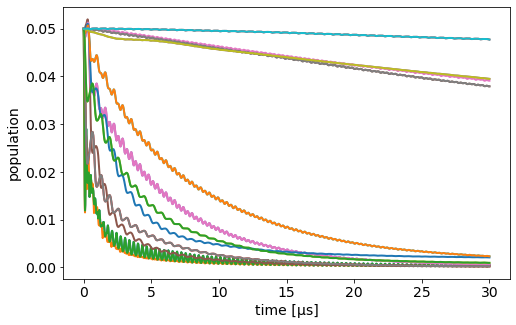

In [38]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in J2_indices:
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array*1e6, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
# ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [39]:
J2_pop_after_rc = np.array([0.00986181, 0.06588223, 0.00986463, 0.05247161, 0.0304416 ,
       0.01240579, 0.03043901, 0.05247163, 0.08678348, 0.00058795,
       0.0008341 , 0.00058789, 0.08678321, 0.05      , 0.05      ,
       0.05      , 0.05      , 0.05      , 0.05      , 0.05      ])

In [40]:
ρ_rc = np.zeros(ρ_ini.shape, dtype = complex)
np.fill_diagonal(ρ_rc[:20,:20], J2_pop_after_rc)
Main.ρ_rc = ρ_rc

In [41]:
Main.eval("""
prob_rc = ODEProblem(Lindblad_rhs!,ρ_rc,tspan,p)
""");

In [42]:
%%time
Main.eval("""
@time sol_rc = solve(prob_rc, Tsit5(), abstol = 1e-7, reltol = 1e-4, progress = false);
tmp = 0
""");

Wall time: 133 ms


0

In [43]:
ut = np.array(Main.eval("sol_rc[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol_rc.t")

In [44]:
print(f'{np.trapz(pop_results[-len(excited_states):].sum(axis = 0), t_array)*Main.Γ}')

1.286210555014071


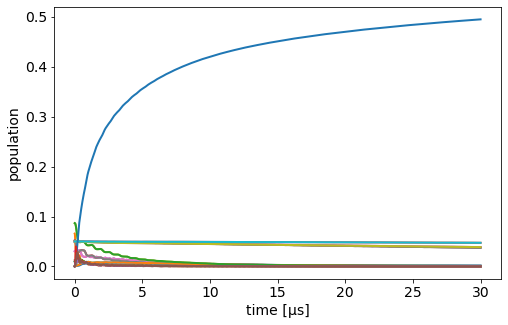

In [45]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in range(0,len(pop_results)):
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
# ax.legend(fontsize = 14)
set_fontsize(ax, 14)

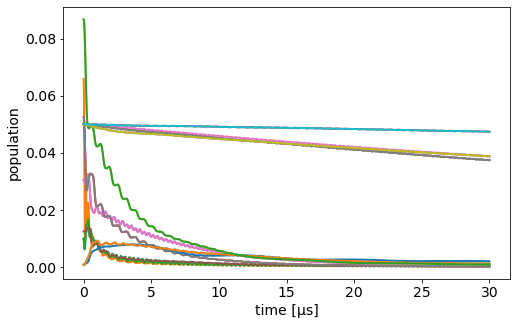

In [46]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in J2_indices:
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array*1e6, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
# ax.legend(fontsize = 14)
set_fontsize(ax, 14)

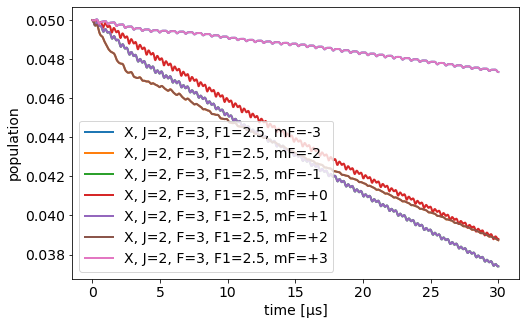

In [47]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in J2_indices[-7:]:
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array*1e6, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [48]:
RC_on = np.trapz(np.real(np.einsum('jji->ji', 
                           np.array(Main.eval("sol_rc.u[:]")).T))[-len(excited_states):].sum(axis = 0), 
                 Main.eval('sol_rc.t'))
RC_off = np.trapz(np.real(np.einsum('jji->ji', 
                           np.array(Main.eval("sol.u[:]")).T))[-len(excited_states):].sum(axis = 0), 
                 Main.eval('sol.t'))

real_depletion = (J2_pop_after_rc.sum() / np.diag(ρ_ini).sum()).real

print(f'ratio RC on/off : {RC_on / RC_off:.2f}')
print(f'depleted J=2 pop : {real_depletion:.2f}')

ratio RC on/off : 0.71
depleted J=2 pop : 0.79


## Scan Rabi Rate

In [49]:
Main.params = np.linspace(0,10,401)*Main.Γ
Main.eval("@everywhere params = $params")

In [50]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
n_excited = H_symbolic_compact.shape[0] - len(excited_states)
Main.eval(f"""
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[{n_excited}:end])) for j in 1:size(sol)[3]]), false
end""")

In [51]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = [params[i], Δ, ωp, ϕ])
end
""")

In [52]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
ens_prob_rc = EnsembleProblem(prob_rc, prob_func = prob_func, output_func = output_func);
""");

In [53]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

246.022222

In [54]:
Main.eval("""
@time sim_rc = solve(ens_prob_rc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 5e-7, reltol = 5e-4)
sim_rc.elapsedTime
""")

260.2720575

<ipython-input-55-18f4ea3804a8>:2: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(Main.params/Main.Γ, np.asarray(Main.sim_rc) / np.asarray(Main.sim), lw = 2)


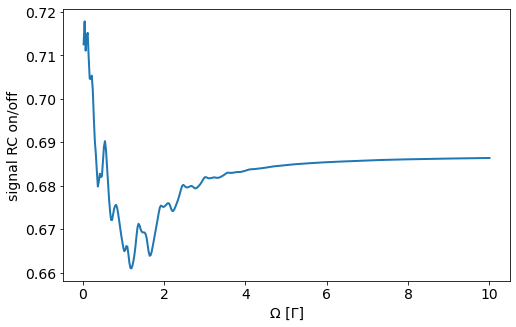

In [55]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim_rc) / np.asarray(Main.sim), lw = 2)

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('signal RC on/off')

set_fontsize(ax, 14)

In [56]:
Main.params = np.linspace(0,2,401)*Main.Γ
Main.eval("@everywhere params = $params")

In [57]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
n_excited = H_symbolic_compact.shape[0] - len(excited_states)
Main.eval(f"""
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[{n_excited}:end])) for j in 1:size(sol)[3]]), false
end""")

In [58]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = [params[i], Δ, ωp, ϕ])
end
""")

In [59]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
ens_prob_rc = EnsembleProblem(prob_rc, prob_func = prob_func, output_func = output_func);
""");

In [60]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

35.9294633

In [61]:
Main.eval("""
@time sim_rc = solve(ens_prob_rc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 5e-7, reltol = 5e-4)
sim_rc.elapsedTime
""")

30.9724032

<ipython-input-62-18f4ea3804a8>:2: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(Main.params/Main.Γ, np.asarray(Main.sim_rc) / np.asarray(Main.sim), lw = 2)


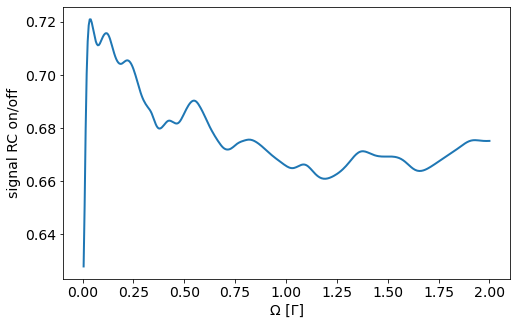

In [62]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim_rc) / np.asarray(Main.sim), lw = 2)

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('signal RC on/off')

set_fontsize(ax, 14)

## Check Population left in J=2 after detection measurement

In [67]:
J2_pop_after_rc = np.array([0.00986181, 0.06588223, 0.00986463, 0.05247161, 0.0304416 ,
       0.01240579, 0.03043901, 0.05247163, 0.08678348, 0.00058795,
       0.0008341 , 0.00058789, 0.08678321, 0.05      , 0.05      ,
       0.05      , 0.05      , 0.05      , 0.05      , 0.05      ])

In [68]:
ρ_rc = np.zeros(ρ_ini.shape, dtype = complex)
np.fill_diagonal(ρ_rc[:20,:20], J2_pop_after_rc)
Main.ρ_rc = ρ_rc

In [69]:
Main.eval("""
prob_rc = ODEProblem(Lindblad_rhs!,ρ_rc,tspan,p)
""");

In [70]:
Main.params = np.linspace(0,10,201)*Main.Γ
Main.eval("@everywhere params = $params")

In [71]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
n_excited = H_symbolic_compact.shape[0] - len(excited_states)
Main.eval(f"""
@everywhere function output_func_popJ2(sol,i)
    p_J2 = real(sum(diag(sol.u[2])[1:20]))
    p_J2_noF3 = real(sum(diag(sol.u[2])[1:13]))
    return [p_J2, p_J2_noF3], false
end""")

In [72]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = [params[i], Δ, ωp, ϕ])
end
""")

In [73]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func_popJ2);
ens_prob_rc = EnsembleProblem(prob_rc, prob_func = prob_func, output_func = output_func_popJ2);
""");


In [74]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 5e-7, reltol = 5e-4, save_everystep = false)
sim.elapsedTime
""")

27.8762628

In [75]:
Main.eval("""
@time sim_rc = solve(ens_prob_rc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 5e-7, reltol = 5e-4, save_everystep = false)
sim_rc.elapsedTime
""")

26.5894365

In [76]:
expected_ratio = (np.diag(ρ_rc).sum() / np.diag(ρ_ini).sum()).real

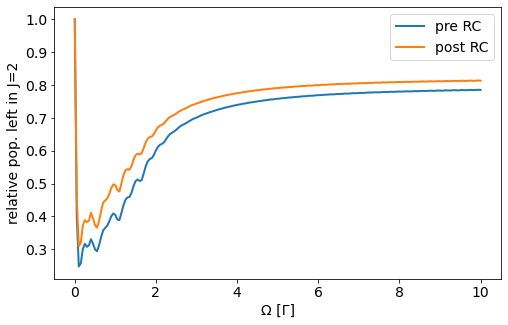

In [77]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim[0]), lw = 2, label = 'pre RC')
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim_rc[0])/expected_ratio, lw = 2, label = 'post RC')

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('relative pop. left in J=2')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

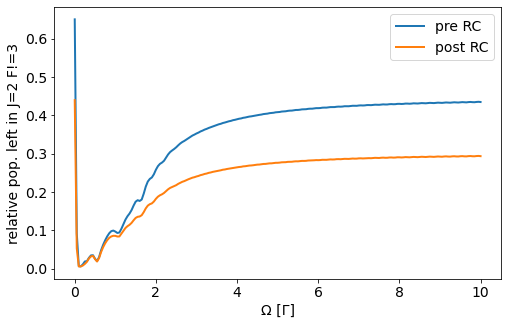

In [78]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim[1]), lw = 2, label = 'pre RC')
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim_rc[1]), lw = 2, label = 'post RC')

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('relative pop. left in J=2 F!=3')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

## Check Population left in J=2 after detection measurement with more interaction time

In [79]:
J2_pop_after_rc = np.array([0.00986181, 0.06588223, 0.00986463, 0.05247161, 0.0304416 ,
       0.01240579, 0.03043901, 0.05247163, 0.08678348, 0.00058795,
       0.0008341 , 0.00058789, 0.08678321, 0.05      , 0.05      ,
       0.05      , 0.05      , 0.05      , 0.05      , 0.05      ])

In [80]:
ρ_rc = np.zeros(ρ_ini.shape, dtype = complex)
np.fill_diagonal(ρ_rc[:20,:20], J2_pop_after_rc)
Main.ρ_rc = ρ_rc

In [81]:
Main.eval("""
prob_rc = ODEProblem(Lindblad_rhs!,ρ_rc,(0., 300e-6),p)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,(0., 300e-6),p)
""");

In [82]:
Main.params = np.linspace(0,10,201)*Main.Γ
Main.eval("@everywhere params = $params")

In [83]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
n_excited = H_symbolic_compact.shape[0] - len(excited_states)
Main.eval(f"""
@everywhere function output_func_popJ2(sol,i)
    p_J2 = real(sum(diag(sol.u[2])[1:20]))
    p_J2_noF3 = real(sum(diag(sol.u[2])[1:13]))
    return [p_J2, p_J2_noF3], false
end""")

In [84]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = [params[i], Δ, ωp, ϕ])
end
""")

In [85]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func_popJ2);
ens_prob_rc = EnsembleProblem(prob_rc, prob_func = prob_func, output_func = output_func_popJ2);
""");


In [86]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 5e-7, reltol = 5e-4, save_everystep = false)
sim.elapsedTime
""")

269.3587511

In [87]:
Main.eval("""
@time sim_rc = solve(ens_prob_rc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 5e-7, reltol = 5e-4, save_everystep = false)
sim_rc.elapsedTime
""")

261.3988672

In [88]:
expected_ratio = (np.diag(ρ_rc).sum() / np.diag(ρ_ini).sum()).real

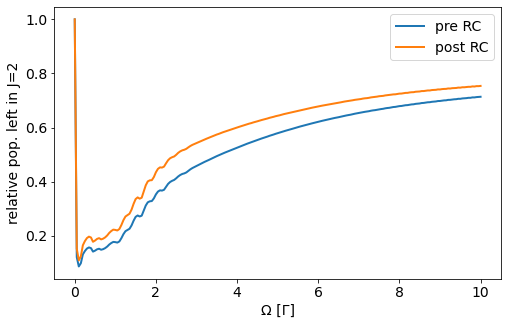

In [89]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim[0]), lw = 2, label = 'pre RC')
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim_rc[0])/expected_ratio, lw = 2, label = 'post RC')

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('relative pop. left in J=2')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

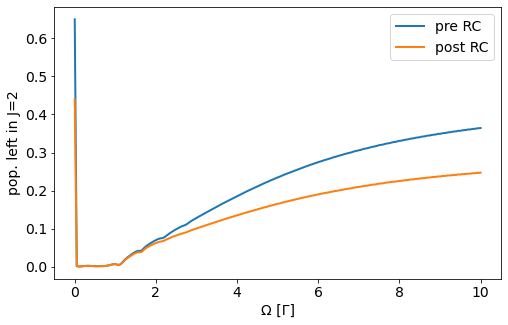

In [90]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim[1]), lw = 2, label = 'pre RC')
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim_rc[1]), lw = 2, label = 'post RC')

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('pop. left in J=2')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)